# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
!python -m spacy download es_core_news_sm
!python -m spacy link es_core_news_sm es

     |████████████████████████████████| 16.2 MB 4.4 MB/s 
  Created wheel for es-core-news-sm: filename=es_core_news_sm-2.2.5-py3-none-any.whl size=16172933 sha256=9012615255c159f3c83dd8efd25614b2d91187a4ece31a6514c9c069a117324f
  Stored in directory: /tmp/pip-ephem-wheel-cache-t5w4s383/wheels/21/8d/a9/6c1a2809c55dd22cd9644ae503a52ba6206b04aa57ba83a3d8
Successfully built es-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/es_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/es
You can now load the model via spacy.load('es')


In [2]:
import spacy
nlp = spacy.load('es')
from spacy.lang.es.stop_words import STOP_WORDS
stopwords_spacy = list(STOP_WORDS)

In [3]:
import itertools

import numpy as np
import pandas as pd
import scipy as sp
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import gc

import nltk

# Esto sirve para configurar NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [4]:
stopwords = STOP_WORDS

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
dataset = pd.read_json('/content/drive/MyDrive/Colab Notebooks/dataset_es_dev.json', lines= True)
dataset.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [9]:
dataset.tail()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
4995,es_0179515,product_es_0158275,reviewer_es_0273644,5,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,es,home
4996,es_0894902,product_es_0953259,reviewer_es_0153773,5,Desempeña su función correctamente,calidad precio,es,camera
4997,es_0760496,product_es_0731995,reviewer_es_0171091,5,Me ha encantado la diadema! Las flores son tal...,Excelente,es,toy
4998,es_0178380,product_es_0402051,reviewer_es_0686937,5,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,es,wireless
4999,es_0810087,product_es_0684221,reviewer_es_0613091,5,El artículo ha cumplido con las expectativas q...,Buena calidad,es,apparel


In [10]:
dataset.shape

(5000, 8)

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_id         5000 non-null   object
 1   product_id        5000 non-null   object
 2   reviewer_id       5000 non-null   object
 3   stars             5000 non-null   int64 
 4   review_body       5000 non-null   object
 5   review_title      5000 non-null   object
 6   language          5000 non-null   object
 7   product_category  5000 non-null   object
dtypes: int64(1), object(7)
memory usage: 312.6+ KB


Vemos que no hay valores nulos.

In [12]:
# Tomamos una instancia de forma aleatoria
index_random = np.random.randint(0,high = dataset.shape[0])
titular = dataset.iloc[index_random].review_body
print(index_random, titular)

1414 El producto ha llegado 1 día tarde y ha llegado abollado como se ve en la foto. Es una caja de cartón y el envoltorio era de plástico por lo que no protegía el paquete


# Análisis exploratorio de datos

1. ¿La distribución de calificaciones es uniforme?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


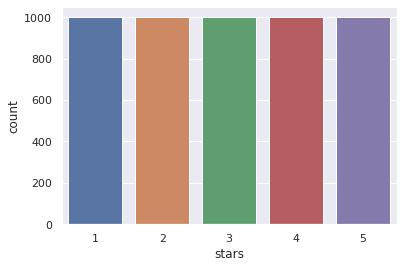

In [13]:
sns.countplot(dataset.stars)
plt.show()

Con este gráfico podemos ver que la distribución de nuestros datos es uniforme. 

2. ¿Qué categorías hay? ¿Cuántas calificaciones recibe cada una?

In [14]:
dataset.product_category.value_counts()

wireless                    672
home                        659
toy                         332
sports                      331
home_improvement            299
pc                          273
electronics                 251
beauty                      195
automotive                  173
kitchen                     156
book                        142
drugstore                   137
furniture                   135
apparel                     133
baby_product                117
office_product              112
other                       103
lawn_and_garden             101
luggage                     101
pet_products                 89
personal_care_appliances     77
camera                       64
shoes                        60
digital_ebook_purchase       51
watch                        47
musical_instruments          46
video_games                  43
industrial_supplies          34
jewelry                      34
grocery                      33
Name: product_category, dtype: int64

In [15]:
dataset.product_category.unique().shape

(30,)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


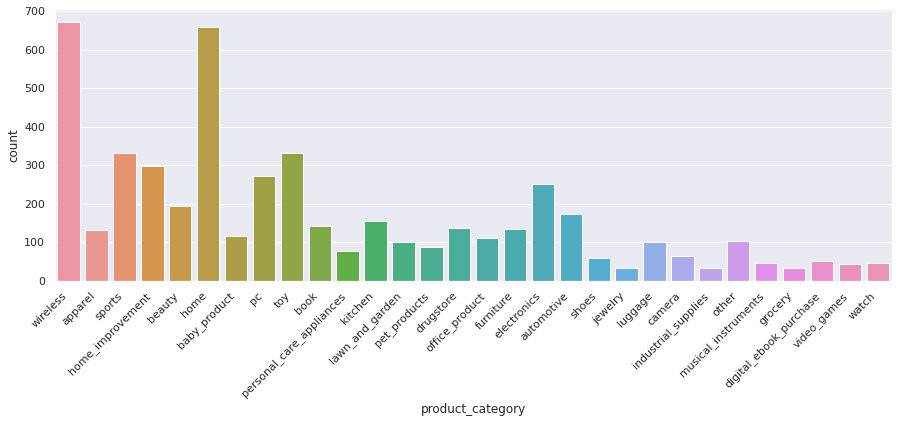

In [16]:
# Visualización
plt.figure(figsize=(15,5))
sns.countplot(dataset['product_category'],data=dataset)
plt.xticks(rotation=45, ha="right")
plt.show()

Vemos que hay 30 categorías diferentes de las cuales Home es la categoría con más calificiaciones y Grocery la categoría con menos calificaciones. 

3. ¿Cúales son las categorías con peores y mejores calificaciones?

In [17]:
ranking_categorias = dataset.stars.groupby([dataset['product_category']]).mean().reset_index(name='mean_stars')
ranking_categorias.sort_values('mean_stars', ascending=False)

,product_category,mean_stars
6,digital_ebook_purchase,3.529412
4,book,3.373239
10,grocery,3.333333
17,luggage,3.287129
20,other,3.252427
21,pc,3.150183
14,jewelry,3.147059
23,pet_products,3.134831
9,furniture,3.133333
3,beauty,3.128205


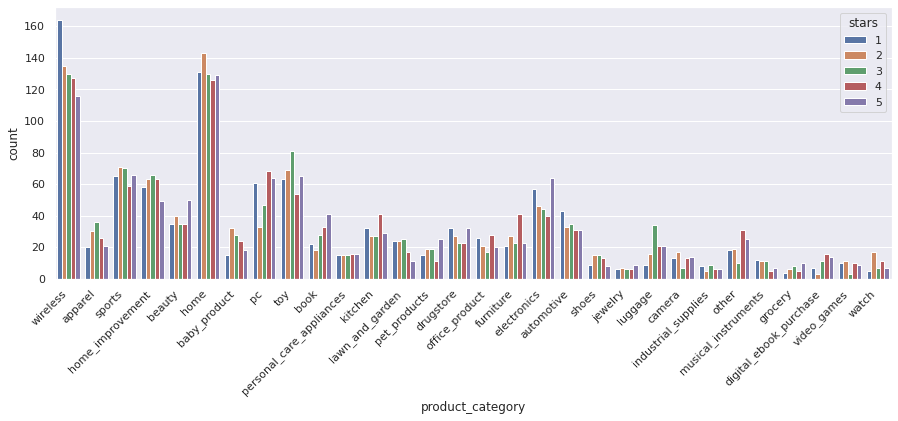

In [18]:
# Visualización
plt.figure(figsize=(15,5))
sns.countplot(x=dataset['product_category'],data=dataset, hue='stars')
plt.xticks(rotation=45, ha="right")
plt.show()

Book es la categoría con el promedio más alto y se puede observar en el gráfico que hay una gran diferencia en la distribución de las calificaciones siendo 5 estrellas la calificación más frecuente. Con Lawn and Garden vemos el mismo comportamiento pero a la inversa, siendo 1 estrella la calificación con más apariciones.

4. ¿Qué palabras estan asociadas a calificaciones negativas?

Comenzamos tomando los documentos con 1 y 2 estrellas categorizandolos como calificaciones negativas.

In [19]:
calificaciones_negativas = dataset[dataset['stars']<= 2]
calificaciones_negativas

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty
...,...,...,...,...,...,...,...,...
1995,es_0030937,product_es_0714707,reviewer_es_0625309,2,"Son muy pequeños,pensé que eran más grandes. N...",Ana Maria,es,jewelry
1996,es_0056828,product_es_0000924,reviewer_es_0953528,2,Es la segunda vez que lo compro. La primera ve...,Capsulas Café,es,grocery
1997,es_0461030,product_es_0254933,reviewer_es_0016628,2,"Tengo que decir que el aparato va bien, pero a...",NO ME HA FUNCIONADO,es,personal_care_appliances
1998,es_0956731,product_es_0005514,reviewer_es_0637278,2,Para bebés nada preciso. No lo recomiendo nada...,No recomendado para bebes,es,personal_care_appliances


Recorremos todos comentarios, los normalizamos y solo tomamos adjetivos para ser mas concretos.

In [20]:
todas_palabras_negativas = []
for i in calificaciones_negativas.index:
    review_NEG = calificaciones_negativas.review_body[i]
    sent = nlp(review_NEG.lower())
    for token in sent:
        if (token.pos_ == "ADJ" and token.text not in stopwords and len(token.text)>2):
            temp = token.lemma_
            todas_palabras_negativas.append(temp) 

In [21]:
todas_palabras_negativas[:5]

['grande', 'aparatoso', 'protector', 'menor', 'mínimo']

In [22]:
freq_rev_1 = nltk.FreqDist(todas_palabras_negativas)
df_frec_pal_neg = pd.DataFrame(freq_rev_1.items(), columns = ['Palabra', 'Frecuencia']) 
df_frec_pal_neg.sort_values(by=['Frecuencia'], inplace=True, ascending=False)
df_frec_pal_neg.reset_index(drop = True, inplace=True)
df_frec_pal_neg.head()

,Palabra,Frecuencia
0,malo,176
1,pequeño,114
2,bonito,67
3,original,45
4,rotar,44


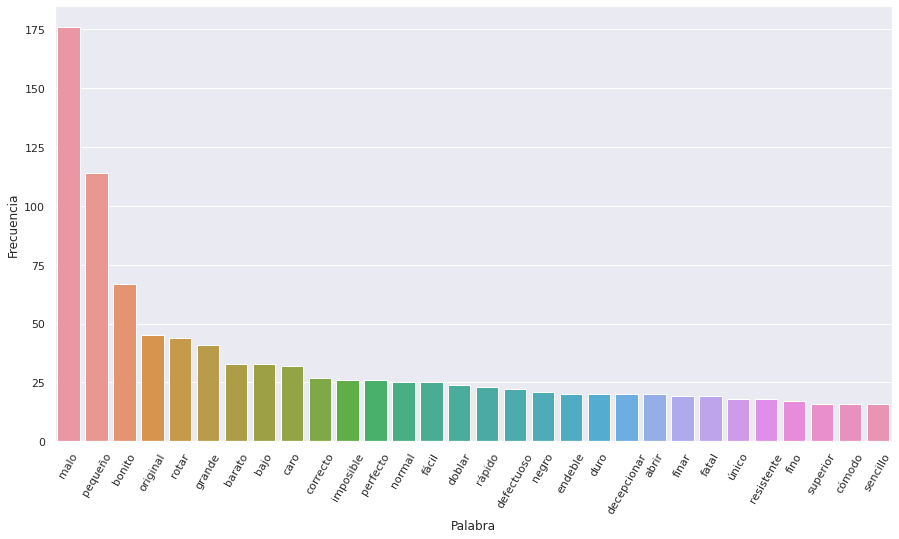

In [27]:
# Visualización 
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_frec_pal_neg.iloc[:30].Palabra, y = df_frec_pal_neg.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(60)
plt.show()

In [24]:
pip install wordcloud

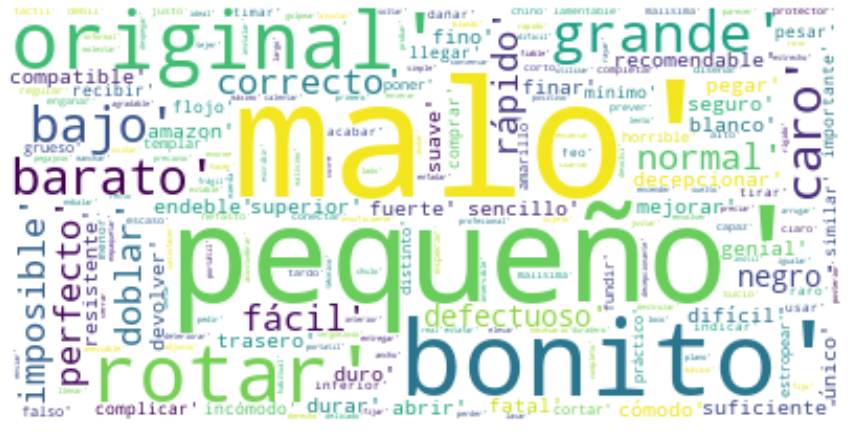

In [25]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white',stopwords = stopwords).generate(str(todas_palabras_negativas))
plt.figure(figsize = (15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

En los gráficos anteriores vemos cuáles son las palabras más utilizadas y cuál es su frecuencia. Si bien una de ellas es "bonito" lo más probable es que sea en un contexto negativo. 

6. ¿Qué palabras estan asociadas a calificaciones positivas? 

In [29]:
calificaciones_positivas = dataset[dataset['stars']>= 4]
calificaciones_positivas

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
3000,es_0638126,product_es_0921838,reviewer_es_0467790,4,Son robustas y francamente cumplen con su come...,Gran juego de llaves.,es,home_improvement
3001,es_0957542,product_es_0016810,reviewer_es_0205107,4,Estupenda relación calidad-precio,Funcional,es,home_improvement
3002,es_0571992,product_es_0161938,reviewer_es_0304170,4,Lo compré para mi madre. Esta muy contenta. Es...,compacto y cómodo,es,furniture
3003,es_0469900,product_es_0182832,reviewer_es_0562273,4,"UN POCO ESTRECHO ,PERO VALE PARA LO QUE ES,PAR...",ESTA BIEN,es,home_improvement
3004,es_0832100,product_es_0922601,reviewer_es_0049840,4,Le doy cuatro estrellas porque aún no lo he pr...,Nice.,es,wireless
...,...,...,...,...,...,...,...,...
4995,es_0179515,product_es_0158275,reviewer_es_0273644,5,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,es,home
4996,es_0894902,product_es_0953259,reviewer_es_0153773,5,Desempeña su función correctamente,calidad precio,es,camera
4997,es_0760496,product_es_0731995,reviewer_es_0171091,5,Me ha encantado la diadema! Las flores son tal...,Excelente,es,toy
4998,es_0178380,product_es_0402051,reviewer_es_0686937,5,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,es,wireless


In [30]:
todas_palabras_positivas = []
for i in calificaciones_positivas.index:
    review_POS = calificaciones_positivas.review_body[i]
    sent = nlp(review_POS.lower())
    for token in sent:
        if (token.pos_ == "ADJ" and token.text not in stopwords and len(token.text)>2):
            temp = token.lemma_
            todas_palabras_positivas.append(temp) 

In [31]:
todas_palabras_positivas[5:10]

['fácil', 'sencillo', 'estrechar', 'finar', 'plástico']

In [32]:
freq_rev_1 = nltk.FreqDist(todas_palabras_positivas)
df_frec_pal_pos = pd.DataFrame(freq_rev_1.items(), columns = ['Palabra', 'Frecuencia']) 
df_frec_pal_pos.sort_values(by=['Frecuencia'], inplace=True, ascending=False)
df_frec_pal_pos.reset_index(drop = True, inplace=True)
df_frec_pal_pos.head()

,Palabra,Frecuencia
0,perfecto,236
1,bonito,118
2,pequeño,116
3,fácil,112
4,cómodo,94


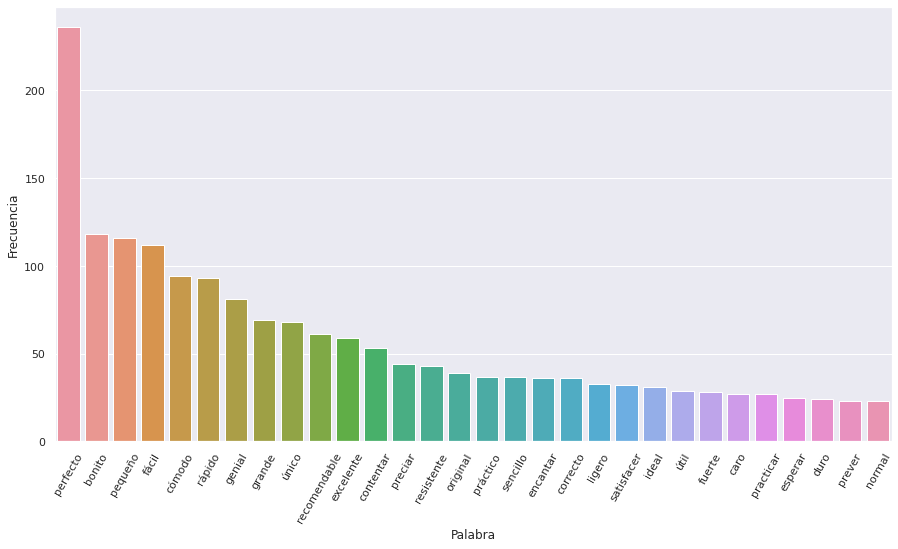

In [34]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_frec_pal_pos.iloc[:30].Palabra, y = df_frec_pal_pos.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(60)
plt.show()

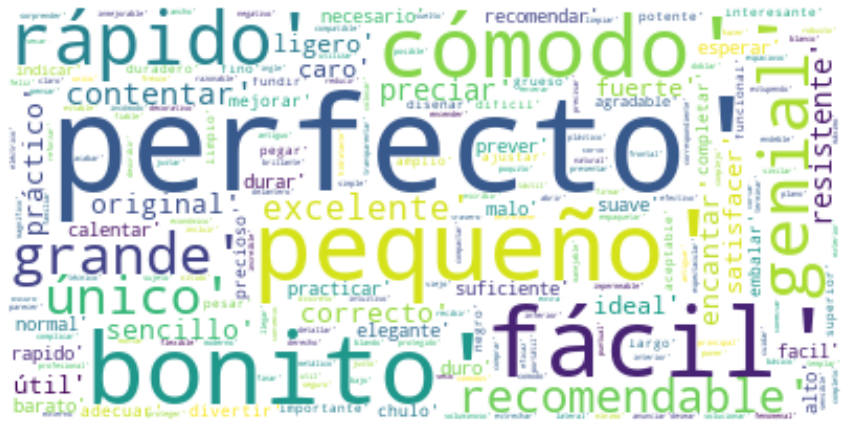

In [35]:
wordcloud = WordCloud(background_color='white',stopwords = stopwords).generate(str(todas_palabras_positivas))
plt.figure(figsize = (15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Nuevamente en los gráficos anteriores podemos observar cuales son las palabras que más se utilizan en calificaciones positivas con su respectiva frecuencia.

## Preprocesamiento 

Importamos nuevamente el dataset

In [36]:
dataset = pd.read_json('/content/drive/MyDrive/Colab Notebooks/dataset_es_dev.json', lines= True)
dataset.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


Seleccionamos las columnas que vamos a utilizar 

In [37]:
dataset=pd.concat([dataset.review_body,dataset.stars],axis=1)
dataset.dropna(axis=0,inplace=True)  # Si hay alguna nan, tiramos esa instancia
dataset.head()

,review_body,stars
0,"Malisimo, muy grande demasiado aparatoso y mal...",1
1,No he recibido el pedido no la devolución,1
2,"Tengo que buscar otro sistema, este no funcion...",1
3,Utilicé las brocas de menor diámetro y se me d...,1
4,No me gusta su olor a viejo y aspecto malo,1


Normalizamos el texto. Le agregamos en este caso el uso de la libreria RE, que nos permite sacar del texto todos los caracteres que no sean palabras.

In [38]:
# Importamos esta libreria que nos permite reemplzar caracteres
import re

In [40]:
dataset.head()

,review_body,stars
0,"Malisimo, muy grande demasiado aparatoso y mal...",1
1,No he recibido el pedido no la devolución,1
2,"Tengo que buscar otro sistema, este no funcion...",1
3,Utilicé las brocas de menor diámetro y se me d...,1
4,No me gusta su olor a viejo y aspecto malo,1


In [41]:
dataset.shape

(5000, 2)

Normalizamos 

In [42]:
# Recorremos todos los titulos y le vamos aplicando la Normalizacion y luega el Stemming a cada uno
titular_list=[]
for titular in dataset.review_body:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    titular=re.sub("[^a-zA-Z]"," ",str(titular))
    # Pasamos todo a minúsculas
    titular=titular.lower()
    # Tokenizamos para separar las palabras del titular
    titular=nltk.word_tokenize(titular)
    # Eliminamos las palabras de menos de 3 letras
    titular = [palabra for palabra in titular if len(palabra)>3]
    # Sacamos las Stopwords
    titular = [palabra for palabra in titular if not palabra in stopwords]
    # Por ultimo volvemos a unir el titular
    titular=" ".join(titular)
    
    # Vamos armando una lista con todos los titulares
    titular_list.append(titular)
titular_list[:1]

['malisimo grande aparatoso protector pantalla']

Aplicamos Lemmatizer para llevar las palabras a raíz reduciendo así un poco más la cantidad de palabras utilizando la información de que rol cumple cada una de estas palabras en cada oración.

In [43]:
titular_lemm=[]
for titular in titular_list:
    titular = nlp(str(titular))
    titular = [palabra.lemma_ for palabra in titular]
    titular =" ".join(titular)
    titular_lemm.append(titular)
titular_lemm[:1]

['malisimo grande aparatoso protector pantalla']

Agregamos al dataset una nueva columna que contenga los las frases luego de lemmatizarlas.

In [44]:
dataset["body_lemm"] = titular_lemm
dataset.head()

,review_body,stars,body_lemm
0,"Malisimo, muy grande demasiado aparatoso y mal...",1,malisimo grande aparatoso protector pantalla
1,No he recibido el pedido no la devolución,1,recibir pedir devoluci
2,"Tengo que buscar otro sistema, este no funcion...",1,buscar sistema funcionar abrazadera agarrar ma...
3,Utilicé las brocas de menor diámetro y se me d...,1,utilic broca menor metro doblar ser mantequill...
4,No me gusta su olor a viejo y aspecto malo,1,gustar olor viejo aspecto malo


Observamos que varias palabras fueron modificadas.

Generamos un dataset llamado dataset_lemm que contenga solo la columna lemmatizada y nuestra variable predictora. 

In [45]:
dataset_lemm=pd.concat([dataset.body_lemm,dataset.stars],axis=1)
dataset_lemm.dropna(axis=0,inplace=True)  # Por si quedaron titulares vacios
dataset_lemm.head()

,body_lemm,stars
0,malisimo grande aparatoso protector pantalla,1
1,recibir pedir devoluci,1
2,buscar sistema funcionar abrazadera agarrar ma...,1
3,utilic broca menor metro doblar ser mantequill...,1
4,gustar olor viejo aspecto malo,1


In [46]:
# Miramos una review al azar
random_index = np.random.randint(0,dataset_lemm.shape[0])
review = dataset_lemm.body_lemm.iloc[random_index]
review

'terminaci stico trasparentar blanco intenso esperar ligero paquete individual'

In [47]:
# Mostramos las POS de la review elegida
sent = nlp(review)
print("{0:20}{1:20}".format("PALABRA:","POS:"))
for token in sent:
    print("{0:20}{1:20}".format(token.text,token.pos_))

PALABRA:            POS:                
terminaci           NOUN                
stico               ADJ                 
trasparentar        VERB                
blanco              ADJ                 
intenso             ADJ                 
esperar             VERB                
ligero              ADJ                 
paquete             NOUN                
individual          ADJ                 


## Vectorización

Generamos una lista de todas las palabras y obtenemos los valores de nuestra variable predictora. 

In [48]:
# Tomamos la lista de palabras y el vector que nos dice si es o no sarcastico el titulo
list_body = list(dataset_lemm['body_lemm'].values)
stars = dataset_lemm['stars'].values

Preparamos el conversor seleccionando n-gramas. Probamos también utilizando 50000 features pero notamos que el modelo comenzaba a sobreajustarse por lo tanto se decidio utilizar solo 10000.

In [77]:
from sklearn.feature_extraction.text import CountVectorizer

# Usaremos solo las 10000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features= 10000

# Es decir que cada instancia tendrá 10000 features
cou_vec = CountVectorizer(max_features=max_features, stop_words= stopwords , ngram_range=(1, 2))

Creamos los vectores para cada título.

In [78]:
matriz_body = cou_vec.fit_transform(list_body)

# Tomamos las palabras
all_words = cou_vec.get_feature_names()

# Vizualizamos 50 palabras
print("50 palabras: ",all_words[0:50])

50 palabras:  ['abajar', 'abertura', 'abollar', 'abonar', 'abonar dinero', 'abonar importar', 'abri', 'abrigar', 'abril', 'abrir', 'abrir cerrar', 'abrir cilmente', 'abrir facilidad', 'abrir faltar', 'abrir paquete', 'abrir poro', 'abrir puerta', 'abrir recomer', 'abrirla', 'abrirlo', 'absolutamente', 'absolutamente recomendable', 'absoluto', 'absorber', 'absurdo', 'abultar', 'aburrir', 'acab', 'acabar', 'acabar bonito', 'acabar comprar', 'acabar cumplir', 'acabar despu', 'acabar estropear', 'acabar llegar', 'acabar malo', 'acabar material', 'acabar pedir', 'acabar producto', 'acabar recibir', 'acabar rompi', 'acaso', 'acceder', 'accesible', 'acceso', 'accesorio', 'accesorio limpieza', 'acci', 'accidentar', 'aceitar']


## Modelización

Al tener unas clases perfectamente balanceadas vamos a utilizar como metrica de evaluación Accuracy Score que nos permite generar un promedio entre todas ellas.

Como primer paso separamos en test y train.

In [79]:
x = matriz_body.toarray()
y = stars

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [80]:
# Chequeamos que la proporción de cada clase en las etiquetas en ambos conjuntos sea parecida
print('Proporcion de etiquetas en los datos de Train: ', ytrain.sum()/ytrain.size)
print('Proporcion de etiquetas en los datos de Test: ', ytest.sum()/ytest.size)

Proporcion de etiquetas en los datos de Train:  3.0
Proporcion de etiquetas en los datos de Test:  3.0


Tambien definimos una función que nos permite plotear los resultados en una matriz de confusión.

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion(ytest,y_pred):
    names=["1star","2stars","3stars","4stars","5stars"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

## Validación cruzada

In [92]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

def k_validacion_cruzada(model,x,y,k):
    scores = cross_val_score(model, x, y, cv=k)
    print("%0.2f de precisión con desviación estándar de %0.2f" % (scores.mean(), scores.std()))


## Benchmark

Comenzamos utilizando un simple Naive Bayes como benchmark

In [82]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(xtrain,ytrain)
Accuracy_Train_NB = nb.score(xtrain,ytrain)
Accuracy_Test_NB = nb.score(xtest,ytest)
print("Accuracy Train: ",Accuracy_Train_NB)
print("Accuracy Test: ",Accuracy_Test_NB)

Accuracy Train:  0.8565
Accuracy Test:  0.308


In [93]:
print('Validación cruzada:')
k_validacion_cruzada(nb,x,stars,5)


Validación cruzada:
0.32 de precisión con desviación estándar de 0.01


Graficamos nuestra matriz de confusión:

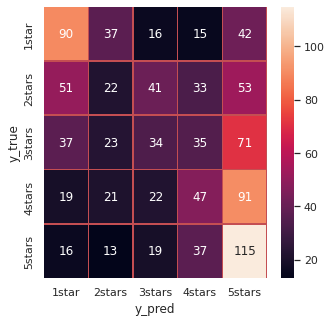

In [83]:
y_pred=nb.predict(xtest)
confusion(ytest,y_pred)

Se observa que los mayores aciertos se encuentran en las calificaciones de 5 y 1 estrella y la mayor dificultad para predecir se produce entre 5 y 4 estrellas.

## Random Forest

Utilizamos Random Forest ya que este modelo nos permite preguntarle por la importancia de las palabras que utiliza para clasificar.

In [84]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier


Optimizaremos sus hiperparametros con RandomSearch ya que son muchos features y esto nos permitirá reducir el costo computacional  

In [85]:
rf = RandomForestClassifier()

In [86]:
# Grilla para Random Search
param_dist = {'n_estimators': sp.stats.randint(30, 50),
              'criterion': ['gini', 'entropy'],
              'min_samples_split':sp.stats.randint(2, 8),
              'min_samples_leaf':sp.stats.randint(1, 4)}

Utilizaremos validación cruzada de 5 folds. Solo haremos 10 intentos para que no tenga un gran costo computacional. 

In [87]:
model = RandomizedSearchCV(rf, param_dist,n_iter=10, random_state=0, cv=5)

# Entrenamos RandomForestClassifier con la grilla definida arriba y CV con tamaño de Fold=5
model.fit(xtrain, ytrain)
print("Mejores parametros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

Mejores parametros: {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 48}
Mejor Score: 0.38075000000000003



Mejores parametros: {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 48}

Mejor Score: 0.38925





Entrenamos el modelo con los resultados de la optimización.

In [95]:
rf = RandomForestClassifier(criterion = 'entropy', min_samples_leaf = 2, min_samples_split= 2, n_estimators = 48, random_state= 42)
rf.fit(xtrain,ytrain)
Accuracy_Train_RF = rf.score(xtrain,ytrain)
Accuracy_Test_RF = rf.score(xtest,ytest)
print("Accuracy Train: ",Accuracy_Train_RF)
print("Accuracy Test: ",Accuracy_Test_RF)

Accuracy Train:  0.68525
Accuracy Test:  0.386


In [96]:
print('Validación cruzada:')
k_validacion_cruzada(rf,x,stars,5)


Validación cruzada:
0.38 de precisión con desviación estándar de 0.01


Graficamos la matriz de confusión:

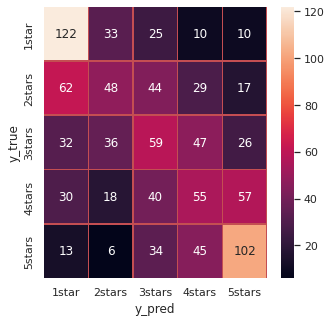

In [89]:
y_pred=rf.predict(xtest)
confusion(ytest,y_pred)

Si bien vemos que el acierto en la clasificación de 5 estrellas bajó también las calificaciones restantes consiguieron un mejor acierto y esto logró que las predicciones sean un poco mas uniformes.

Vemos cuales son las palabras que mayormente determinan el clasificador.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


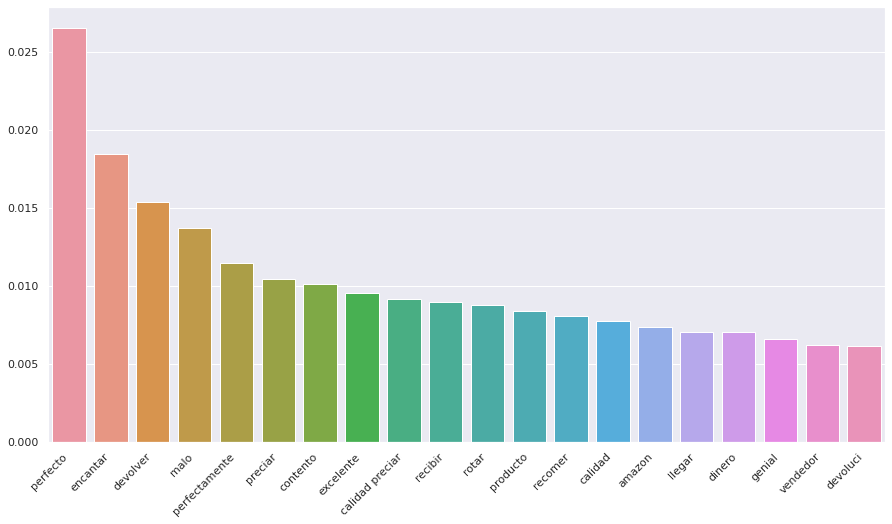

In [90]:
# Le preguntamos la importancia de cada feature (cada palabra)
importances = rf.feature_importances_
# Tomamos la lista de palabras
all_words = cou_vec.get_feature_names()
columns = all_words

# Ordenamos por importancia y tomamos las 20 primeras
indices = np.argsort(importances)[::-1]
indices = indices[:20]
selected_columns = [columns[i] for i in indices]
selected_importances = importances[indices]

# Por ultimo graficamos
plt.figure(figsize = (15,8))
sns.barplot(selected_columns, selected_importances)
plt.xticks(rotation=45, ha="right")
plt.show()

## Investigación 

Me gustaría probar el mismo proceso pero solo con la columna de titulares ya que al ser una expresión corta tiende a ser un poco más concreta. 


In [99]:
# Importamos nuevamente el dataset
dataset = pd.read_json('/content/drive/MyDrive/Colab Notebooks/dataset_es_dev.json', lines= True)
# Seleccionamos en este caso la columna review_title
dataset = dataset[['review_title', 'stars']]

Normalizamos

In [100]:
titular_list=[]
for titular in dataset.review_title:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    titular=re.sub("[^a-zA-Z]"," ",str(titular))
    # Pasamos todo a minúsculas
    titular=titular.lower()
    # Tokenizamos para separar las palabras del titular
    titular=nltk.word_tokenize(titular)
    # Eliminamos las palabras de menos de 3 letras
    titular = [palabra for palabra in titular if len(palabra)>3]
    # Sacamos las Stopwords
    titular = [palabra for palabra in titular if not palabra in stopwords]
    # Por ultimo volvemos a unir el titular
    titular=" ".join(titular)
    
    # Vamos armando una lista con todos los titulares
    titular_list.append(titular)
titular_list[4:5]

['gusta']

Lemmatizamos

In [101]:
titular_lemm=[]
for titular in titular_list:
    titular = nlp(str(titular))
    titular = [palabra.lemma_ for palabra in titular]
    titular =" ".join(titular)
    titular_lemm.append(titular)
titular_lemm[:1]

['malo comprar']

Creamos el nuevo dataset con los titulares lemmatizados

In [102]:
dataset["titular_lemm"] = titular_lemm
dataset = dataset[['titular_lemm', 'stars']]
dataset.head(1)

,titular_lemm,stars
0,malo comprar,1


Vectorizamos

In [103]:
# Tomamos la lista de palabras y el vector que nos dice si es o no sarcastico el titulo
list_body = list(dataset['titular_lemm'].values)
stars = dataset_lemm['stars'].values

In [104]:
# Usaremos solo las 10000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features= 10000
cou_vec = CountVectorizer(max_features=max_features, stop_words= stopwords , ngram_range=(1, 2))

In [105]:
matriz_body = cou_vec.fit_transform(list_body)
all_words = cou_vec.get_feature_names()

Modelamos

In [106]:
x = matriz_body.toarray()
y = stars

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [107]:
# Chequeamos que la proporción de cada clase en las etiquetas en ambos conjuntos sea parecida
print('Proporcion de etiquetas en los datos de Train: ', ytrain.sum()/ytrain.size)
print('Proporcion de etiquetas en los datos de Test: ', ytest.sum()/ytest.size)

Proporcion de etiquetas en los datos de Train:  3.0
Proporcion de etiquetas en los datos de Test:  3.0


In [108]:
rf = RandomForestClassifier()

In [109]:
# Grilla para Random Search
param_dist = {'n_estimators': sp.stats.randint(30, 50),
              'criterion': ['gini', 'entropy'],
              'min_samples_split':sp.stats.randint(2, 8),
              'min_samples_leaf':sp.stats.randint(1, 4)}

In [110]:
model = RandomizedSearchCV(rf, param_dist,n_iter=10, random_state=0, cv=5)

# Entrenamos RandomForestClassifier con la grilla definida arriba y CV con tamaño de Fold=5
model.fit(xtrain, ytrain)
print("Mejores parametros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

Mejores parametros: {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 46}
Mejor Score: 0.35225



Mejores parametros: {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 46}

Mejor Score: 0.35225

In [111]:
rf = RandomForestClassifier(criterion = 'entropy', min_samples_leaf = 1, min_samples_split= 5, n_estimators = 46, random_state= 42)
rf.fit(xtrain,ytrain)
print("Accuracy Train: ",rf.score(xtrain,ytrain))
print("Accuracy Test: ",rf.score(xtest,ytest))

Accuracy Train:  0.73425
Accuracy Test:  0.362


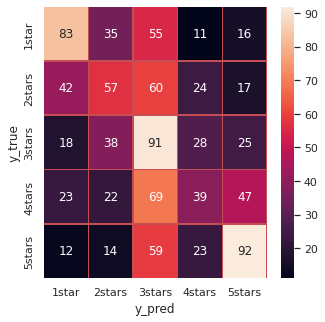

In [113]:
y_pred=rf.predict(xtest)
confusion(ytest,y_pred)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


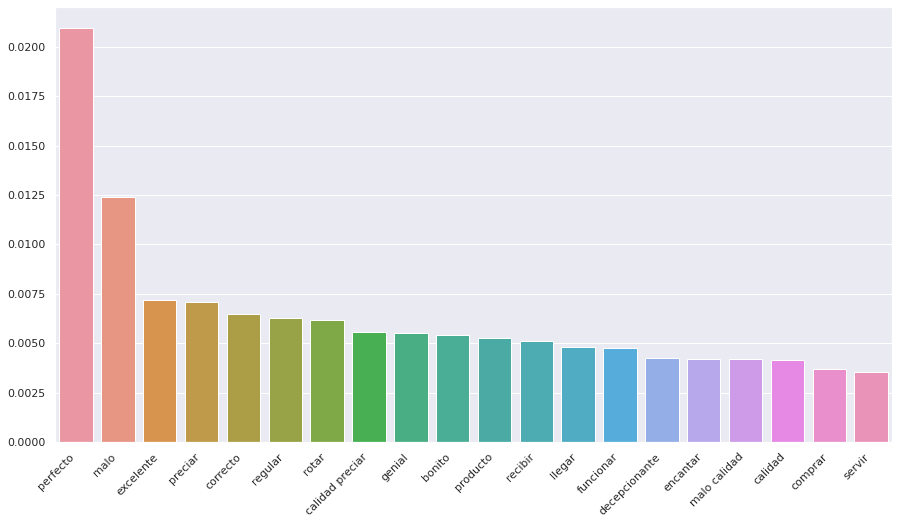

In [115]:
# Le preguntamos la importancia de cada feature (cada palabra)
importances = rf.feature_importances_
# Tomamos la lista de palabras
all_words = cou_vec.get_feature_names()
columns = all_words

# Ordenamos por importancia y tomamos las 20 primeras
indices = np.argsort(importances)[::-1]
indices = indices[:20]
selected_columns = [columns[i] for i in indices]
selected_importances = importances[indices]

# Por ultimo graficamos
plt.figure(figsize = (15,8))
sns.barplot(selected_columns, selected_importances)
plt.xticks(rotation=45, ha="right")
plt.show()

No mejoró debido a que tiene muy poca información pero otra propuesta de mejora sería incorporar un preprocesamiento de datos mucho más detallado.